In [1]:
import xarray as xr
import geopandas
import regionmask

In [2]:
import functions as fn
rez_boundary = fn.get_REZ_boundary()

# Load single instance of ERA5 grid
This is to be used with `regionmask` to create our mask

In [3]:
era5_instance = xr.open_dataset('/g/data/rt52/era5/single-levels/monthly-averaged/2t/2010/2t_era5_moda_sfc_20100101-20100131.nc')

# Load Renewable Energy Zone (REZ) boundaries

In [4]:
rez_file = '/g/data/w42/dr6273/work/data/REZ_boundaries_2021/Indicative_REZ_boundaries_2021_-_GIS_data-polygon.shp'
rez_gpd = geopandas.read_file(rez_file)

In [5]:
rez_gpd.head()

Name descriptio  tessellate  \
0               Q1 Far North QLD        REZ           1   
1  Q2 North Qld Clean Energy Hub        REZ           1   
2                Q3 Northern Qld        REZ           1   
3                       Q4 Isaac        REZ           1   
4                  Q5 Barcaldine        REZ           1   

                                            geometry  
0  POLYGON ((146.13492 -17.65256, 146.09725 -17.9...  
1  POLYGON ((143.72015 -16.97938, 143.87955 -16.9...  
2  POLYGON ((146.27782 -18.71920, 146.28263 -18.7...  
3  POLYGON ((147.64366 -19.94015, 147.68341 -19.9...  
4  POLYGON ((145.82086 -23.84279, 145.70040 -23.8...

# Create REZ mask

In [16]:
def create_mask(gpd_df, template_ds, boundary=None, lon_name='longitude', lat_name='latitude'):
    """
    Create mask from shapefiles and a template xarray dataArray or dataset.
    """
    mask = regionmask.mask_3D_geopandas(
        gpd_df,
        template_ds[lon_name],
        template_ds[lat_name]
    )
    
    if lon_name != 'lon':
        mask = mask.rename({lon_name: 'lon'})
    if lat_name != 'lat':
        mask = mask.rename({lat_name: 'lat'})
        
    if isinstance(boundary, list):
        mask = mask.sel(
            lon=slice(boundary[0], boundary[1]),
            lat=slice(boundary[2], boundary[3])
        )
        
    return mask

In [29]:
rez_mask = create_mask(
    rez_gpd,
    era5_instance,
    rez_boundary
)

### Add and sort by the region code (N1, N2, etc.)

In [30]:
rez_codes = rez_gpd['Name']
rez_codes = [i[:2] for i in rez_codes]

In [31]:
rez_mask = rez_mask.assign_coords({
    'region': rez_codes
})

In [32]:
rez_mask = rez_mask.sortby('region')

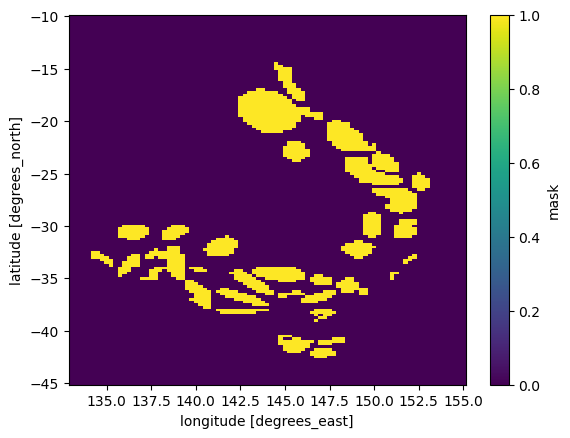

In [33]:
rez_mask.sum('region').plot()

# Renewables type coding

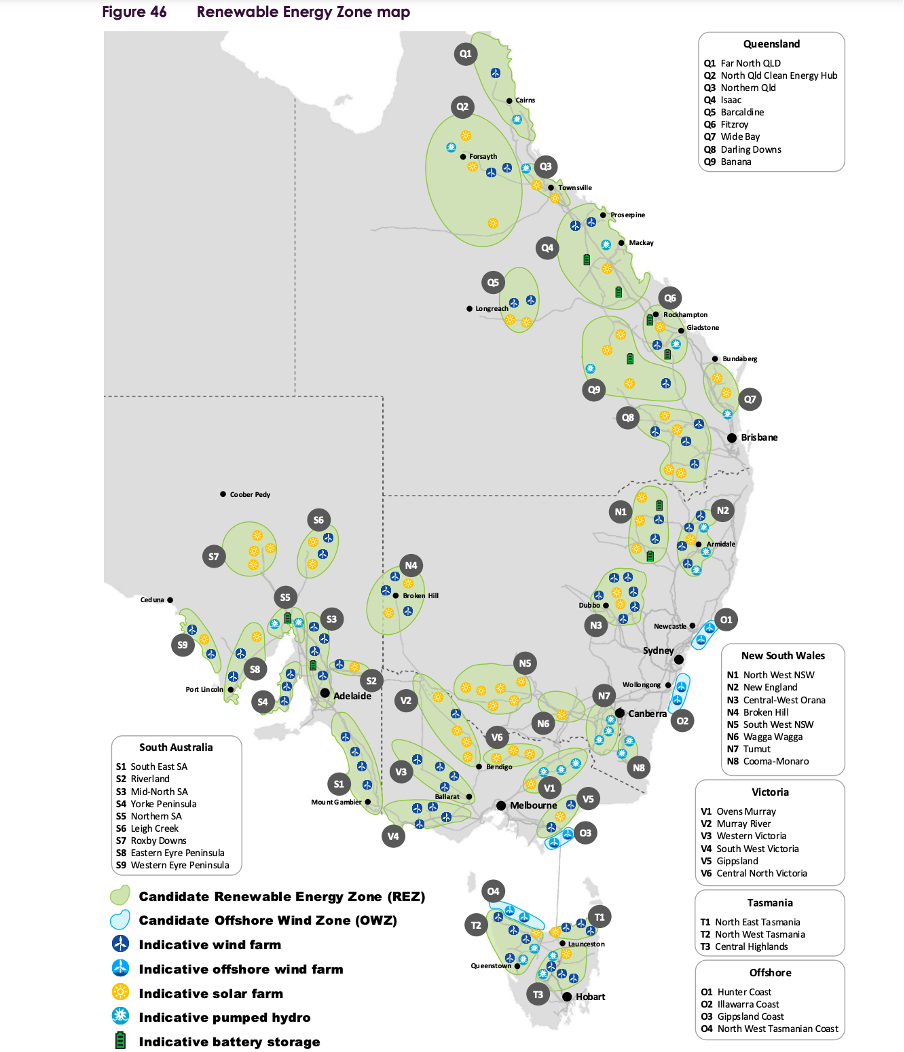

We code each region according to the type of renewables:
1. Wind
2. Solar
3. Wind and solar
4. Hydro
5. Hydro and wind
6. Hydro and solar
7. All three

Offshore is classed as wind.

In [15]:
rez_mask.region.values

array(['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'O1', 'O2', 'O3',
       'O4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'S1',
       'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'T1', 'T2', 'T3',
       'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], dtype='<U2')

In [58]:
region_codes = [
    3, 7, 3, 3, 2, 2, 4, 4,     # NSW
    1, 1, 1, 1,                 # Offshore wind
    5, 7, 6, 7, 3, 7, 6, 3, 7,  # QLD
    1, 3, 1, 1, 4, 3, 2, 3, 3,  # SA
    3, 7, 7,                    # TAS
    6, 3, 1, 1, 3, 2            # VIC
]

In [17]:
rez_mask = rez_mask.assign_coords(
    region_code=('region', region_codes)
)

# Convert to `dataset` and save

In [18]:
rez_mask_ds = rez_mask.to_dataset(name='REZ')

In [19]:
rez_mask_ds.to_netcdf('/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_mask_era5_grid.nc')

# Load ABS Greater Capital Cities Statistical Areas (GCCSA)

Downloaded from: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files

Information here: https://www.abs.gov.au/websitedbs/censushome.nsf/home/factsheetsgeography/$file/Greater%20Capital%20City%20Statistical%20Area%20-%20Fact%20Sheet.pdf

In [6]:
gccsa_file = '/g/data/w42/dr6273/work/data/ABS_GCCSA_2021/GCCSA_2021_AUST_GDA2020.shp'
gccsa_gpd = geopandas.read_file(gccsa_file)

Select Sydney, Melbourne, Brisbane, Adelaide, Canberra and Hobart

In [7]:
gccsa_gpd = gccsa_gpd.loc[
    (gccsa_gpd['GCC_NAME21'] == 'Greater Sydney') |
    (gccsa_gpd['GCC_NAME21'] == 'Greater Melbourne') |
    (gccsa_gpd['GCC_NAME21'] == 'Greater Brisbane') |
    (gccsa_gpd['GCC_NAME21'] == 'Greater Adelaide') |
    (gccsa_gpd['GCC_NAME21'] == 'Australian Capital Territory') |
    (gccsa_gpd['GCC_NAME21'] == 'Greater Hobart')
]

In [8]:
# gccsa_gpd = gccsa_gpd.set_index('GCC_NAME21')

In [9]:
gccsa_gpd

GCC_CODE21                    GCC_NAME21 CHG_FLAG21  CHG_LBL21 STE_CODE21  \
0       1GSYD                Greater Sydney          0  No change          1   
4       2GMEL             Greater Melbourne          0  No change          2   
8       3GBRI              Greater Brisbane          0  No change          3   
12      4GADE              Greater Adelaide          0  No change          4   
20      6GHOB                Greater Hobart          0  No change          6   
28      8ACTE  Australian Capital Territory          0  No change          8   

                      STE_NAME21 AUS_CODE21 AUS_NAME21  AREASQKM21  \
0                New South Wales        AUS  Australia  12368.6858   
4                       Victoria        AUS  Australia   9992.6081   
8                     Queensland        AUS  Australia  15842.0073   
12               South Australia        AUS  Australia   3259.8859   
20                      Tasmania        AUS  Australia   1695.3611   
28  Australian Capital Territory        AUS  Australia   2358.1330   

                                           LOCI_URI21  \
0   http://linked.data.gov.au/dataset/asgsed3/GCCS...   
4   http://linked.data.gov.au/dataset/asgsed3/GCCS...   
8   http://linked.data.gov.au/dataset/asgsed3/GCCS...   
12  http://linked.data.gov.au/dataset/asgsed3/GCCS...   
20  http://linked.data.gov.au/dataset/asgsed3/GCCS...   
28  http://linked.data.gov.au/dataset/asgsed3/GCCS...   

                                             geometry  
0   MULTIPOLYGON (((151.28159 -33.83318, 151.28151...  
4   MULTIPOLYGON (((144.88829 -38.50260, 144.88825...  
8   MULTIPOLYGON (((153.23213 -27.42089, 153.23254...  
12  MULTIPOLYGON (((138.65522 -34.55213, 138.65589...  
20  MULTIPOLYGON (((147.60058 -42.86784, 147.60041...  
28  POLYGON ((149.06239 -35.15910, 149.09134 -35.1...

# Create GCCSA mask

In [52]:
gccsa_mask = create_mask(
    gccsa_gpd,
    era5_instance,
    rez_boundary
)

Rename region dimension as city codes

In [53]:
city_codes = [
    'SYD',
    'MLB',
    'BNE',
    'ADL',
    'HBA',
    'ACT'
]

In [60]:
gccsa_mask['region'] = city_codes

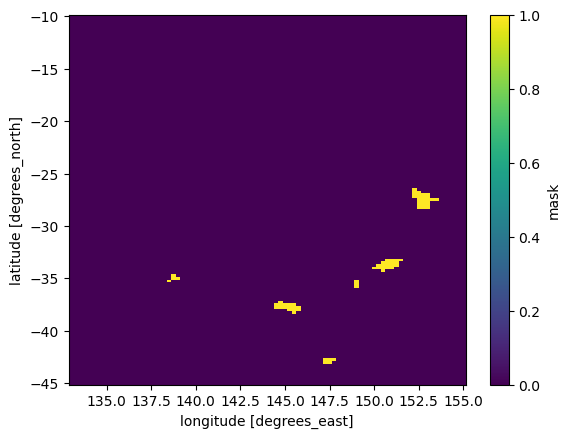

In [62]:
gccsa_mask.sum('region').plot()

# Convert to `dataset` and save

In [63]:
gccsa_mask_ds = gccsa_mask.to_dataset(name='GCCSA')

In [64]:
gccsa_mask_ds.to_netcdf('/g/data/w42/dr6273/work/projects/Aus_energy/data/gccsa_mask_era5_grid.nc')